資料集 二

In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def generate_data():
    # 設置隨機種子
    np.random.seed(45)

    # 生成數據
    data = {
        'Class': ['A'] * 100 + ['B'] * 200 + ['C'] * 100 + ['D'] * 400 + ['E'] * 400 + ['F'] * 200 + ['G'] * 100,
        'Drink': ['7Up'] * 100 + ['Sprite'] * 200 + ['Pepsi'] * 100 + ['Coke'] * 400 + ['Cappuccino'] * 400 + ['Espresso'] * 200 + ['Latte'] * 100,
        'Rank': [7] * 100 + [6] * 200 + [5] * 100 + [4] * 400 + [3] * 400 + [2] * 200 + [1] * 100,
        'Amount': np.concatenate([
            np.random.normal(loc=100, scale=200, size=100),
            np.random.normal(200, 10, 200),
            np.random.normal(200, 10, 100),
            np.random.normal(400, 100, 400),
            np.random.normal(800, 10, 400),
            np.random.normal(800, 10, 200),
            np.random.normal(900, 400, 100)
        ]),
        'Quantity': np.concatenate([
            np.random.randint(low=500, high=1001, size=800),  # Class A-D
            np.random.randint(1, 501, 700)     # Class E-G
        ])
    }

    # 將數據轉換為DataFrame
    df = pd.DataFrame(data)

    return df

data = generate_data()

In [2]:
scaler = StandardScaler()
data[['Rank', 'Amount', 'Quantity']] = scaler.fit_transform(data[['Rank', 'Amount', 'Quantity']])

In [3]:
# One-Hot Encoding
onehot_encoder = OneHotEncoder()
drink_onehot = onehot_encoder.fit_transform(data[['Drink']]).toarray()
data_onehot = pd.concat([data.drop(columns=['Drink']), pd.DataFrame(drink_onehot, columns=onehot_encoder.get_feature_names_out(['Drink']))], axis=1)

創建相似度function

In [4]:
# 克隆模型存儲庫
!git clone https://huggingface.co/fse/word2vec-google-news-300

# 安裝 gensim 庫
!pip install gensim

Cloning into 'word2vec-google-news-300'...
remote: Enumerating objects: 11, done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 11 (from 1)
Unpacking objects: 100% (11/11), 1.51 KiB | 171.00 KiB/s, done.
Filtering content: 100% (2/2), 3.52 GiB | 36.33 MiB/s, done.


In [4]:
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 加載預訓練的Word2Vec模型
model_path = 'word2vec-google-news-300/word2vec-google-news-300.model'
model = KeyedVectors.load(model_path)

# 函數：計算一組詞的相似度矩陣
def compute_similarity_matrix(words, model):
    word_vectors = [model[word] for word in words if word in model]
    similarity_matrix = cosine_similarity(word_vectors)
    return similarity_matrix

tSNE 主程式

In [5]:
# 使用 t-SNE 進行降維 (1-of-k編碼)
features_encoded = data_onehot.drop(['Class'], axis=1)

tsne_encoded = TSNE(n_components=2, random_state=45)
tsne_result_encoded = tsne_encoded.fit_transform(features_encoded)

#------------------------------------------------------------------------#

# 使用 t-SNE 進行降維 (相似度)
unique_drinks = data['Drink'].unique()

# 計算這些獨特飲料類別的相似度矩陣
similarity_matrix = compute_similarity_matrix(unique_drinks, model)

# 將相似度矩陣轉換為DataFrame，以便於合併
similarity_df = pd.DataFrame(similarity_matrix, index=unique_drinks, columns=unique_drinks)

# 將相似度信息合併回原始數據
data_with_similarity = data.merge(similarity_df, how='left', left_on='Drink', right_index=True)

# 可選地，丟棄原始的 'Drink' 欄位，保留相似度分數
data_with_similarity = data_with_similarity.drop(columns=['Drink'])

# 提取用於 t-SNE 的特徵（如果有其他特徵也可以一併提取）
features = data_with_similarity.drop(columns=['Class'])

# 初始化 t-SNE 模型
tsne = TSNE(n_components=2, random_state=42)

# 將特徵降維到二維空間
features_tsne = tsne.fit_transform(features)

# 將 t-SNE 結果轉換為 DataFrame 以便於後續處理
tsne_df = pd.DataFrame(features_tsne, columns=['Dimension 1', 'Dimension 2'])

# 合併 t-SNE 結果與原始數據（包含相似度信息）
data_with_tsne = pd.concat([data_with_similarity, tsne_df], axis=1)

In [6]:
# 定義映射字典
class_mapping = {
    'A': '7Up',
    'B': 'Sprite',
    'C': 'Pepsi',
    'D': 'Coke',
    'E': 'Cappuccino',
    'F': 'Espresso',
    'G': 'Latte'
}

# 將 data['Class'] 依照映射字典轉換成對應的飲料名稱
data['Class'] = data['Class'].map(class_mapping)

# 將 data_with_tsne['Class'] 依照映射字典轉換成對應的飲料名稱
data_with_tsne['Class'] = data_with_tsne['Class'].map(class_mapping)

單純顯示圖

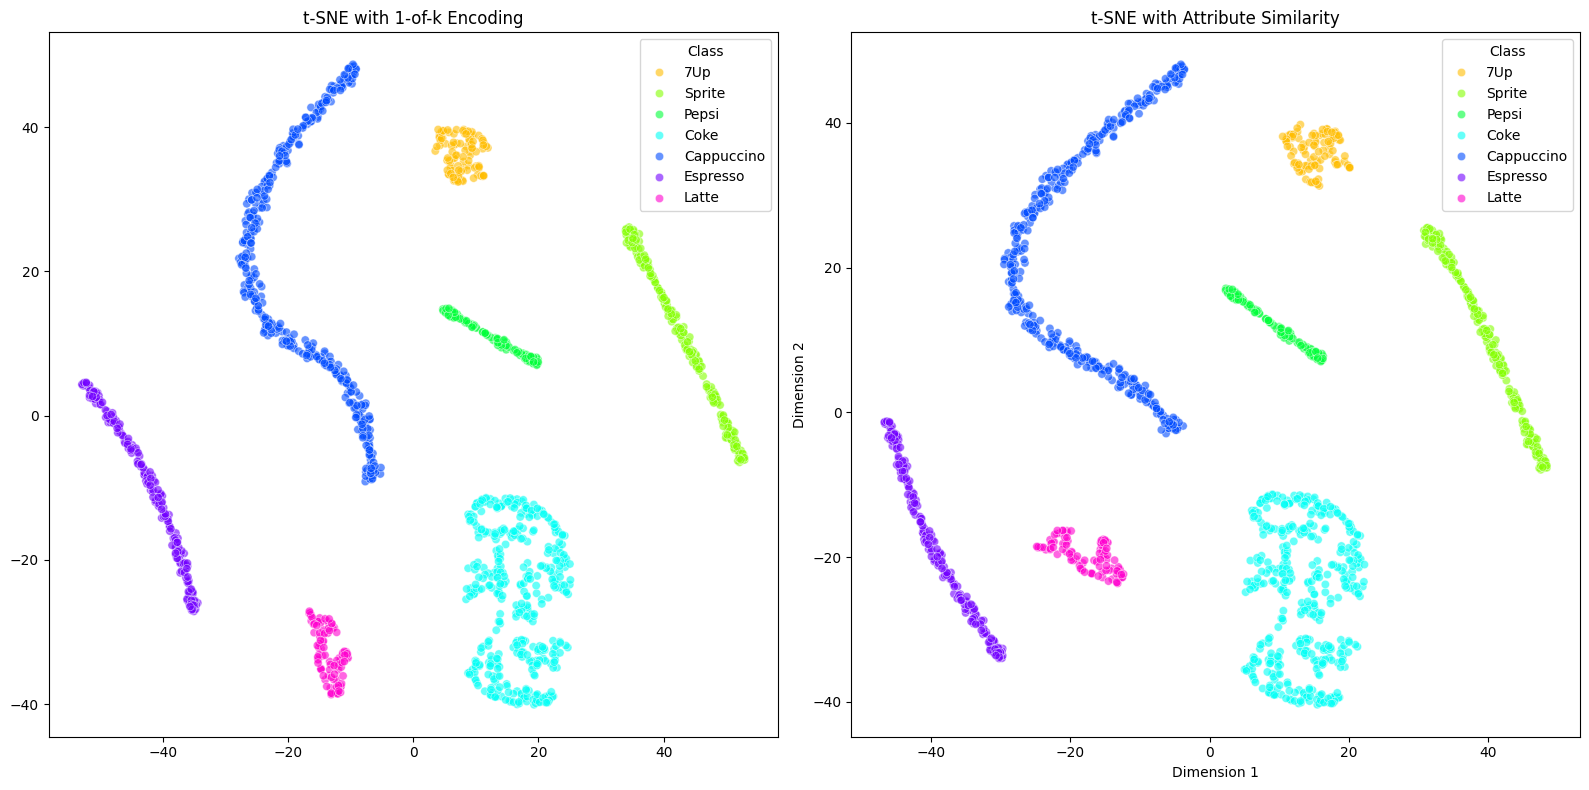

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))

# 繪製 1-of-k編碼 的結果
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=tsne_result_encoded[:, 0], y=tsne_result_encoded[:, 1],
    hue=data['Class'],
    palette=sns.color_palette("hsv", 7),
    legend='full',
    alpha=0.6
)
plt.title('t-SNE with 1-of-k Encoding')

# 繪製 考慮屬性值相似度 的結果
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=data_with_tsne['Dimension 1'], y=data_with_tsne['Dimension 2'],
    hue=data_with_tsne['Class'],
    palette=sns.color_palette("hsv", 7),
    legend='full',
    alpha=0.6
)
plt.title('t-SNE with Attribute Similarity')

plt.tight_layout()
plt.show()

Dash圖

In [8]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd
import numpy as np


app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1('t-SNE Results with Dash'),

    html.Div([
        dcc.Graph(
            id='tsne-1ofk',
            figure=px.scatter(
                x=tsne_result_encoded[:, 0],
                y=tsne_result_encoded[:, 1],
                color=data['Class'],
                color_discrete_sequence=px.colors.qualitative.Plotly,
                opacity=0.6,
                title='t-SNE with 1-of-k Encoding'
            )
        ),
    ], style={'width': '49%', 'display': 'inline-block'}),

    html.Div([
        dcc.Graph(
            id='tsne-attributes',
            figure=px.scatter(
                x=data_with_tsne['Dimension 1'],
                y=data_with_tsne['Dimension 2'],
                color=data_with_tsne['Class'],
                color_discrete_sequence=px.colors.qualitative.Plotly,
                opacity=0.6,
                title='t-SNE with Attribute Similarity'
            )
        ),
    ], style={'width': '49%', 'float': 'right', 'display': 'inline-block'}),

])

if __name__ == '__main__':
    app.run_server(debug=True)


<ipython-input-8-d33283ae5f19>:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-8-d33283ae5f19>:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


<IPython.core.display.Javascript object>